# Dataset Preparation

In [1]:
import sys
sys.path.append("../")
from ImportData import ProcessExperiment
import seaborn as sns
import matplotlib.pyplot as plt
import glob, os
from PoincareSection import *
import pandas as pd
from Utils import HH_Hamiltonian
import Features
from Features import *
from LabelDataset import *
from Utils import RunExperiment
os.chdir("../")

Parameters to run the simulations:

In [2]:
Tstep = 1e-3
Tprint = 1e-0
Tf = 100000.0
solver = 1
w0 = 1.0
w1 = (np.sqrt(5.0)+1.0) / 2.0
q0 = 0.0
E = 0.17
p1 = 0.0

## Read the data

Read experiments and label datapoints:

In [3]:
FOLDER = "Runs_Grid_Wide"

exps = []
count = 0

sali_tresh = 1e-4
megno_tresh = 100
fli_tresh = 5.0

os.chdir(FOLDER)
for file in glob.glob("[!test_]*.json"):
    print(file)
    print(count)
    count+=1
    
    file = file.split(".")[0]
    exp = ProcessExperiment(file, "../" + FOLDER, 4)
    
    
    exp["label_MEGNO"] = MEGNO_Label(exp, megno_tresh)
    exp["label_SALI"] = SALI_Label(exp, sali_tresh)
    fl = FLI_Label(exp,fli_tresh)
    exp["label_FLI"] = fl
       
    exp["allsame"] = (exp["label_MEGNO"] == exp["label_SALI"]) and (exp["label_MEGNO"] == exp["label_FLI"])
    
    if not exp["allsame"]:
        plane = Plane(np.array([1.0, 0, 0, 0]), 0)
        sec = PoincareSection(plane)

        inters = np.array(sec.ComputeFromOrbit(exp["orbit"]))
        exp["inters"] = inters
    else:
        exp["inters"] = None
        
    exps.append(exp)
    

ZLAXYP1622556741_15.json
0
ZLAXYP1622556741_21.json
1
ZLAXYP1622556741_32.json
2
ZLAXYP1622556741_26.json
3
ZLAXYP1622556741_4.json
4
ZLAXYP1622556741_13.json
5
ZLAXYP1622556741_43.json
6
ZLAXYP1622556741_28.json
7
ZLAXYP1622556741_34.json
8
ZLAXYP1622556741_23.json
9
ZLAXYP1622556741_39.json
10
ZLAXYP1622556741_29.json
11
ZLAXYP1622556741_14.json
12
ZLAXYP1622556741_3.json
13
ZLAXYP1622556741_5.json
14
ZLAXYP1622556741_45.json
15
ZLAXYP1622556741_46.json
16
ZLAXYP1622556741_37.json
17
ZLAXYP1622556741_47.json
18
ZLAXYP1622556741_19.json
19
ZLAXYP1622556741_8.json
20
ZLAXYP1622556741_0.json
21
ZLAXYP1622556741_12.json
22
ZLAXYP1622556741_6.json
23
ZLAXYP1622556741_42.json
24
ZLAXYP1622556741_41.json
25
ZLAXYP1622556741_30.json
26
ZLAXYP1622556741_27.json
27
ZLAXYP1622556741_9.json
28
ZLAXYP1622556741_31.json
29
ZLAXYP1622556741_35.json
30
ZLAXYP1622556741_44.json
31
ZLAXYP1622556741_24.json
32
ZLAXYP1622556741_40.json
33
ZLAXYP1622556741_20.json
34
ZLAXYP1622556741_2.json
35
ZLAXYP1622

In [5]:
df = pd.DataFrame(exps)

## Agreement analysis

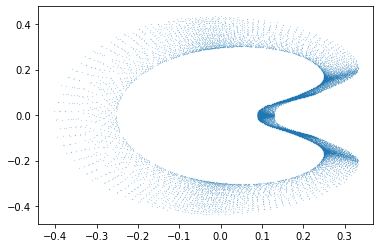

In [5]:
notsame = df[df["allsame"] == False]
inters = notsame.iloc[0]["inters"]
plt.scatter(inters[:,1], inters[:,3], s=0.01)

Only keep the rows with agreeing indicators:

In [6]:
allsame = df[df["allsame"] == True]
allsame["label"] = list(allsame["label_FLI"])

/home/marcobellan/Code/University/Tesi/Tesi_Python/tesi/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Compute features

In [22]:
def GetLen(df):
    return len(df.iloc[0]["SALI"])

def GetSlice(df, ratio):
    Nold = GetLen(df)
    Nnew = int((Nold - 1) * ratio + 1)
    
    short = df.copy()
    
    salis = []
    flis = []
    megnos = []
    
    for idx in range(len(short)):
        salis.append( short.iloc[idx]["SALI"][0:Nnew] )
        flis.append( short.iloc[idx]["FLI"][0:Nnew] )       
        megnos.append( short.iloc[idx]["MEGNO"][0:Nnew] )   
        
    short["SALI"] = salis
    short["FLI"] = flis
    short["MEGNO"] = megnos
    
    return short

def GetFeatures(df):
    exps = []
    
    for idx, row in df.iterrows():
        exp = row.copy()
        exp = ValidFeature(exp)
        exp = DeltaEFeature(exp)
        exp = MegnoLinearFitFeature(exp, 0.5)
        exp = SALIExpFitFeature(exp, 0.5)
        exp = SALIFFTFeature(exp)
        exp = FLIExpFitFeature(exp, 0.5)
        exp = FLIFFTFeature(exp)

        exps.append(exp)
        
    return pd.DataFrame(exps)

def Finalise(df):
    todrop = ["SALI", "FLI", "MEGNO", "orbit", "tangents", "inters", "allsame",
              "label_FLI", "label_MEGNO", "label_SALI"]
    
    return df.drop(columns=todrop)

In [23]:
treshes = [0.1, 0.05, 0.01, 0.005, 0.001]

for tresh in treshes:
    reduced = GetSlice(allsame, tresh)
    N = GetLen(reduced)
    
    feats = GetFeatures(reduced)
    feats = Finalise(feats)
    
    #feats.to_csv("Dataset_512_" + str(N))

../Features.py:37: RuntimeWarning: divide by zero encountered in log
  l_sali = np.log(exp["SALI"])
../Features.py:37: RuntimeWarning: divide by zero encountered in log
  l_sali = np.log(exp["SALI"])
../Features.py:37: RuntimeWarning: divide by zero encountered in log
  l_sali = np.log(exp["SALI"])
../Features.py:37: RuntimeWarning: divide by zero encountered in log
  l_sali = np.log(exp["SALI"])
../Features.py:37: RuntimeWarning: divide by zero encountered in log
  l_sali = np.log(exp["SALI"])
../Features.py:37: RuntimeWarning: divide by zero encountered in log
  l_sali = np.log(exp["SALI"])
../Features.py:37: RuntimeWarning: divide by zero encountered in log
  l_sali = np.log(exp["SALI"])


In [24]:
N = GetLen(reduced)

In [25]:
feats

,w0,w1,q0,E,q1,p1,Tstep,Tf,Tprint,solver,...,feature_sali_score,feature_sali_max_freq,feature_sali_peak_ratio,feature_sali_symmetric,feature_fli_slope,feature_fli_intercept,feature_fli_score,feature_fli_max_freq,feature_fli_peak_ratio,feature_fli_symmetric
0,1.0,1.618034,0.0,0.17,-0.122779,0.0,0.001,100000.0,0.1,1,...,0.031345,1168.696430,0.486086,0.991851,6.305781e-06,0.148193,6.001904e-01,7.371154,0.409036,0.945357
1,1.0,1.618034,0.0,0.17,-0.004324,0.0,0.001,100000.0,0.1,1,...,0.171248,1023.922604,0.389065,0.910137,3.674686e-05,0.394589,8.705273e-01,9.650620,0.265728,0.552169
2,1.0,1.618034,0.0,0.17,0.212843,0.0,0.001,100000.0,0.1,1,...,0.014155,580.581660,0.329364,0.963408,5.587044e-06,0.893082,1.226788e-01,8.156533,0.379322,0.999597
3,1.0,1.618034,0.0,0.17,0.094388,0.0,0.001,100000.0,0.1,1,...,0.196599,615.164587,0.316704,0.954719,-1.162618e-07,0.883676,9.437276e-05,7.833566,0.449441,0.959215
5,1.0,1.618034,0.0,0.17,-0.162264,0.0,0.001,100000.0,0.1,1,...,0.022384,1070.898053,0.488446,0.997586,1.193296e-06,0.131956,9.694635e-02,7.098833,0.545826,0.994200
6,1.0,1.618034,0.0,0.17,0.430010,0.0,0.001,100000.0,0.1,1,...,0.029847,871.134354,0.433324,0.985316,2.385714e-06,0.814894,3.802049e-02,7.914895,0.465550,0.982471
7,1.0,1.618034,0.0,0.17,0.133873,0.0,0.001,100000.0,0.1,1,...,0.026033,615.900743,0.368523,0.971133,6.957077e-06,0.834363,3.192805e-01,8.187741,0.431026,0.875870
8,1.0,1.618034,0.0,0.17,0.252328,0.0,0.001,100000.0,0.1,1,...,0.020895,572.546420,0.328043,0.970054,3.143192e-06,0.992714,3.130905e-02,8.158681,0.395472,0.969911
9,1.0,1.618034,0.0,0.17,0.035161,0.0,0.001,100000.0,0.1,1,...,0.128140,754.158177,0.444038,0.943714,1.647026e-06,0.586060,2.903511e-02,7.634221,0.467197,0.895359
10,1.0,1.618034,0.0,0.17,0.351040,0.0,0.001,100000.0,0.1,1,...,0.008730,652.693133,0.431509,0.973104,-1.183985e-06,1.118292,5.764969e-03,8.111987,0.547924,0.979939


# Example feature

In [7]:
allsame

,w0,w1,q0,E,q1,p1,Tstep,Tf,Tprint,solver,...,FLI,MEGNO,orbit,tangents,label_MEGNO,label_SALI,label_FLI,allsame,inters,label
0,1.0,1.618034,0.0,0.17,-0.122779,0.0,0.001,100000.0,0.1,1,...,"[1.0, 0.9990969735551914, 0.9966592751596973, ...","[-0.00018094673498787235, -0.00038037312742286...","[[0.0, -0.12277902551753145, 0.560691302675503...","[[[1.0, 0.0, 0.0, 0.0], [0.9962273013951092, -...",False,False,False,True,None,False
1,1.0,1.618034,0.0,0.17,-0.004324,0.0,0.001,100000.0,0.1,1,...,"[1.0, 0.9999743385338133, 1.0000937306743072, ...","[-5.14503441836093e-06, 8.110297736863032e-06,...","[[0.0, -0.004324180437722869, 0.58306919934821...","[[[1.0, 0.0, 0.0, 0.0], [0.9950472563027978, -...",True,True,True,True,None,True
2,1.0,1.618034,0.0,0.17,0.212843,0.0,0.001,100000.0,0.1,1,...,"[1.0, 1.003396761877137, 1.013046888708914, 1....","[0.0006041800676021338, 0.0013250826024000047,...","[[0.0, 0.21284303554192618, 0.5226162404695206...","[[[1.0, 0.0, 0.0, 0.0], [0.9928840636973799, -...",False,False,False,True,None,False
3,1.0,1.618034,0.0,0.17,0.094388,0.0,0.001,100000.0,0.1,1,...,"[1.0, 1.001505247075954, 1.0057742277480723, 1...","[0.0002258369573685983, 0.0005110588415610075,...","[[0.0, 0.09438819046211755, 0.5710913544963279...","[[[1.0, 0.0, 0.0, 0.0], [0.9940639509263621, -...",False,False,False,True,None,False
5,1.0,1.618034,0.0,0.17,-0.162264,0.0,0.001,100000.0,0.1,1,...,"[1.0, 0.9989270403138288, 0.9959787032864492, ...","[-0.00021495527282915344, -0.00045717367777006...","[[0.0, -0.16226397387746766, 0.542724227154253...","[[[1.0, 0.0, 0.0, 0.0], [0.9966206687156276, -...",False,False,False,True,None,False
6,1.0,1.618034,0.0,0.17,0.430010,0.0,0.001,100000.0,0.1,1,...,"[1.0, 1.0078784737742679, 1.0301417290595407, ...","[0.0015829856024890954, 0.003389413076133553, ...","[[0.0, 0.43001025152157524, 0.3063000293714138...","[[[1.0, 0.0, 0.0, 0.0], [0.9907211637084584, -...",False,False,False,True,None,False
7,1.0,1.618034,0.0,0.17,0.133873,0.0,0.001,100000.0,0.1,1,...,"[1.0, 1.002135415227319, 1.008193228688858, 1....","[0.0003397038264823113, 0.0007571658030203631,...","[[0.0, 0.13387313882205376, 0.5591073999431935...","[[[1.0, 0.0, 0.0, 0.0], [0.993670645551562, -0...",False,False,False,True,None,False
8,1.0,1.618034,0.0,0.17,0.252328,0.0,0.001,100000.0,0.1,1,...,"[1.0, 1.0040279410176165, 1.015481588864566, 1...","[0.0007547565533523475, 0.0016463317115593976,...","[[0.0, 0.2523279839018624, 0.49768575530548964...","[[[1.0, 0.0, 0.0, 0.0], [0.9924907872677708, -...",False,False,False,True,None,False
9,1.0,1.618034,0.0,0.17,0.035161,0.0,0.001,100000.0,0.1,1,...,"[1.0, 1.0005606254119581, 1.0021554546584812, ...","[7.803820850240175e-05, 0.00018990403472599667...","[[0.0, 0.03516076792221329, 0.5814023018641516...","[[[1.0, 0.0, 0.0, 0.0], [0.9946539269781687, -...",False,False,False,True,None,False
10,1.0,1.618034,0.0,0.17,0.351040,0.0,0.001,100000.0,0.1,1,...,"[1.0, 1.0058975938119732, 1.0226944593894793, ...","[0.0011845234051866738, 0.0025556641528261324,...","[[0.0, 0.3510403548017028, 0.4116427251449126,...","[[[1.0, 0.0, 0.0, 0.0], [0.9915076386776475, -...",False,False,False,True,None,False


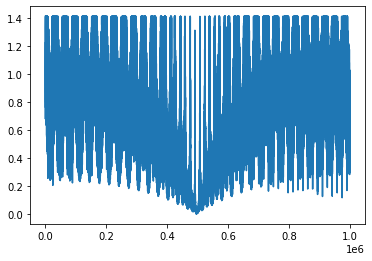

In [17]:
plt.plot(allsame.iloc[0]["SALI"])

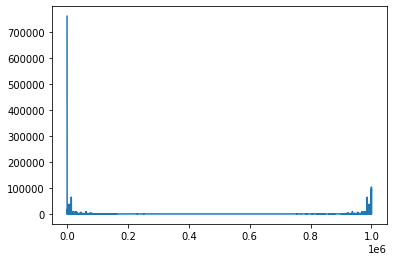

In [20]:
plt.plot(np.abs(fft(allsame.iloc[0]["SALI"])))